### Image Classification with CNN
#### Dogs vs Cats Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "./courses/fastai/courses/dl1/data/dogscats/"
sz=224

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [7]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [8]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.7875.jpg',
 'cat.2153.jpg',
 'cat.9099.jpg',
 'cat.1460.jpg',
 'cat.4689.jpg']

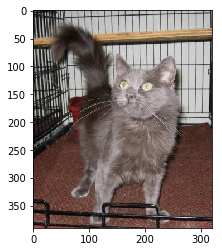

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[1]}')
plt.imshow(img);

In [10]:
img.shape

(390, 321, 3)

In [12]:
img[:2,:2]

array([[[33, 35, 32],
        [20, 22, 19]],

       [[30, 32, 29],
        [24, 26, 23]]], dtype=uint8)

In [13]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

### Model: ResNet34
#### Easy steps to train a world-class image classifier
1. precompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
2. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.047372   0.023089   0.9935    
    1      0.035464   0.021204   0.993                        



[array([0.0212]), 0.993]

### Analyzing Results: Looking at Pictures
1. A few correct labels at random
1. A few incorrect labels at random
1. The most correct labels of each class (i.e. those with highest probability that are correct)
1. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
1. The most uncertain labels (i.e. those with probability closest to 0.5)

In [15]:
data.val_y # Label for a valid data

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
data.classes

['cats', 'dogs']

In [17]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [18]:
log_preds[:10]

array([[ -0.00003, -10.47365],
       [ -0.00001, -11.40426],
       [ -0.00003, -10.29938],
       [ -0.00001, -11.66823],
       [ -0.00039,  -7.85348],
       [ -0.     , -12.35244],
       [ -0.00074,  -7.21216],
       [ -0.00004, -10.18127],
       [ -0.00006,  -9.76699],
       [ -0.     , -12.71067]], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [20]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [21]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [22]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [23]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


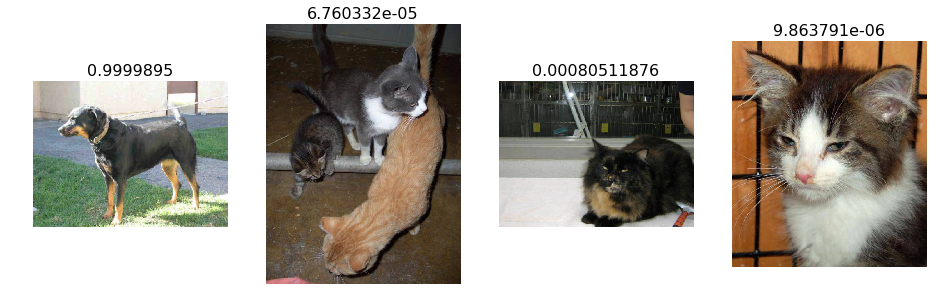

In [24]:
# A few correct labels at Random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


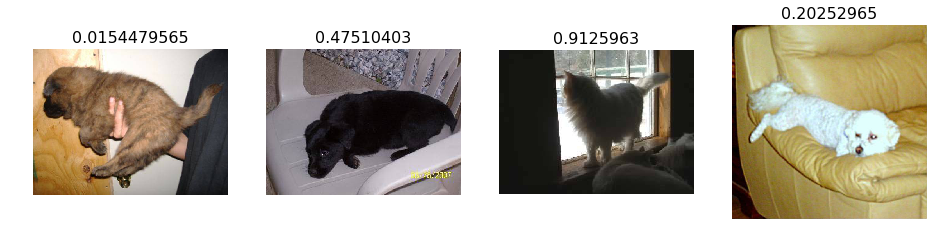

In [25]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [26]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


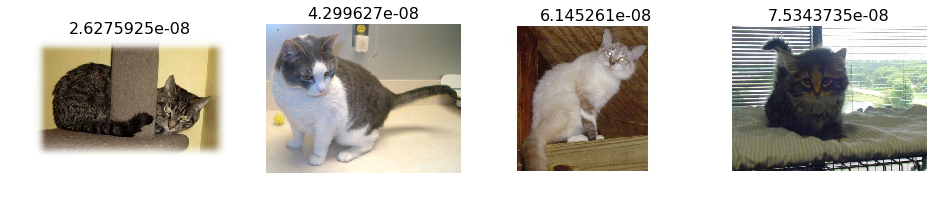

In [27]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


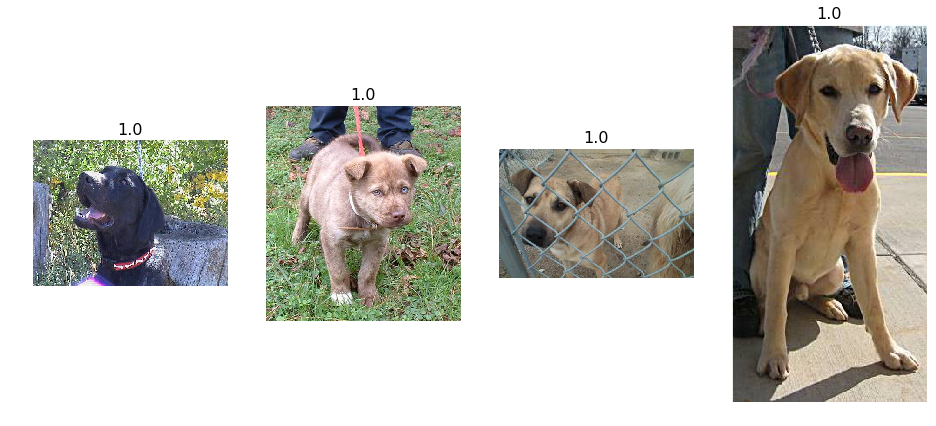

In [28]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


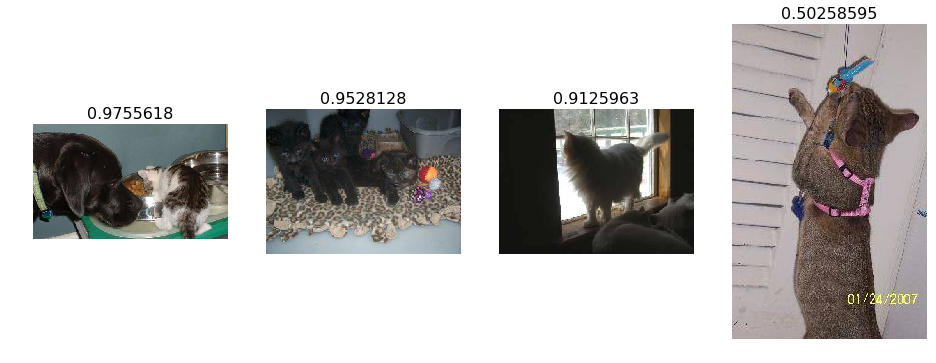

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


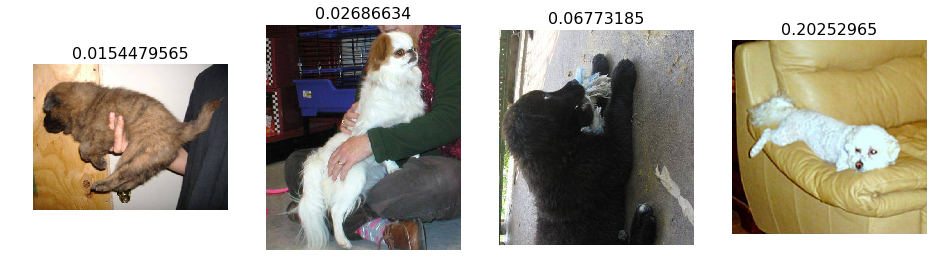

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


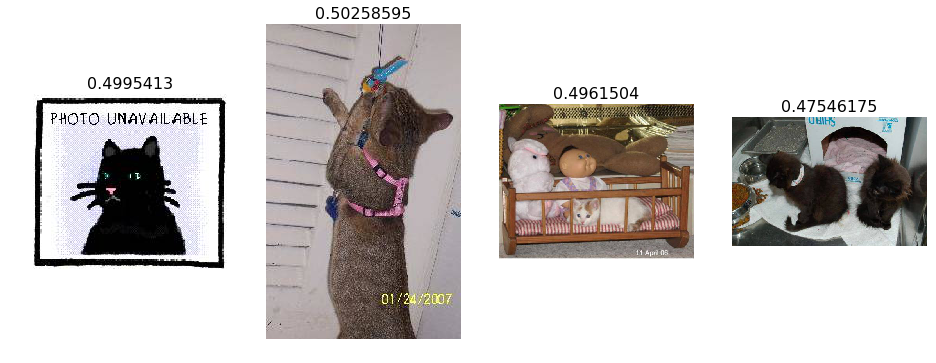

In [31]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Choosing a Learning Rate

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf=learn.lr_find()

 80%|████████  | 288/360 [00:06<00:01, 45.47it/s, loss=0.46]  


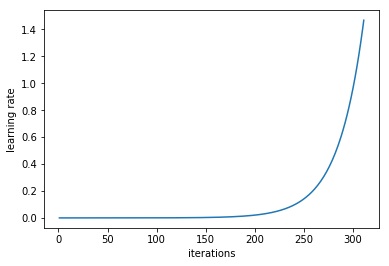

In [34]:
learn.sched.plot_lr()

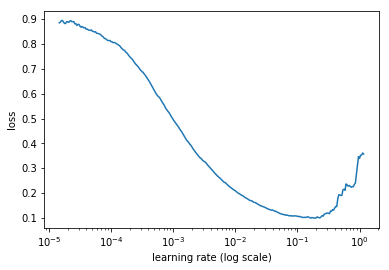

In [35]:
learn.sched.plot()

### Improving Our Model
#### Data Augmentation
1. In case of overfitting (model is learning to recognize the specific images in the training set, rather than generalizing). One way to fix this is to effectively create more data, through data augmentation. 
2. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.
3. We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.


In [36]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [37]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [38]:
ims = np.stack([get_augs() for i in range(6)])

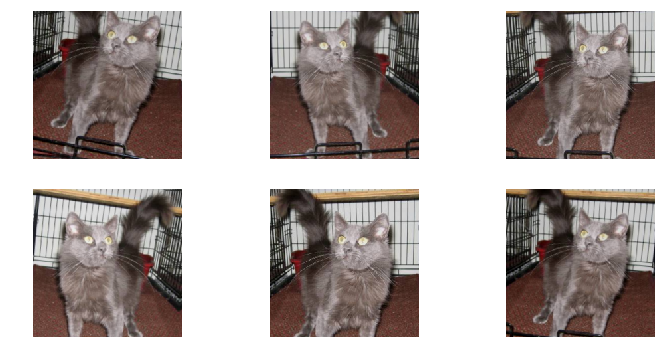

In [40]:
plots(ims, rows=2)

### Create a new Data object that includes this augmentations.. 

In [41]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [42]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.056561   0.02843    0.99      



[array([0.02843]), 0.99]

In [43]:
learn.precompute=False

In [44]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.046218   0.027295   0.9915    
    1      0.053561   0.028148   0.9905                       
    2      0.042352   0.026348   0.9915                       



[array([0.02635]), 0.9915]

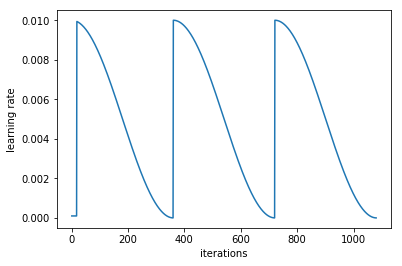

In [45]:
learn.sched.plot_lr()

In [46]:
learn.save('224_lastlayer')

In [47]:
learn.load('224_lastlayer')

### Fine Tuning and differential learning rate annealing

In [48]:
learn.unfreeze()

In [49]:
lr=np.array([1e-4,1e-3,1e-2])

In [50]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.049899   0.02702    0.989     
    1      0.039169   0.021496   0.991                        
    2      0.029665   0.020351   0.991                        
    3      0.034423   0.025577   0.9915                       
    4      0.02011    0.020171   0.9925                       
    5      0.019677   0.020571   0.9915                       
    6      0.0166     0.020408   0.992                        



[array([0.02041]), 0.992]

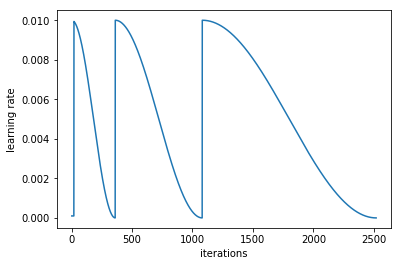

In [51]:
learn.sched.plot_lr()

In [52]:
learn.save('224_all')

In [53]:
learn.load('224_all')

### Test Time Augmentation (TTA)
#### TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's TTA() method.

In [54]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [55]:
accuracy_np(probs, y)

0.993

### Analyzing Results
#### Confusion Matrix

In [56]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[992   8]
 [  6 994]]


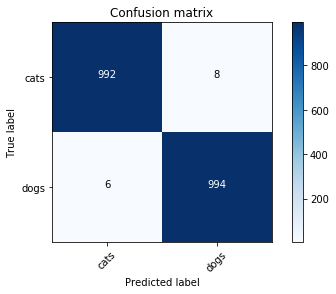

In [60]:
plot_confusion_matrix(cm, data.classes)

### Looking Pictures again

Most incorrect cats


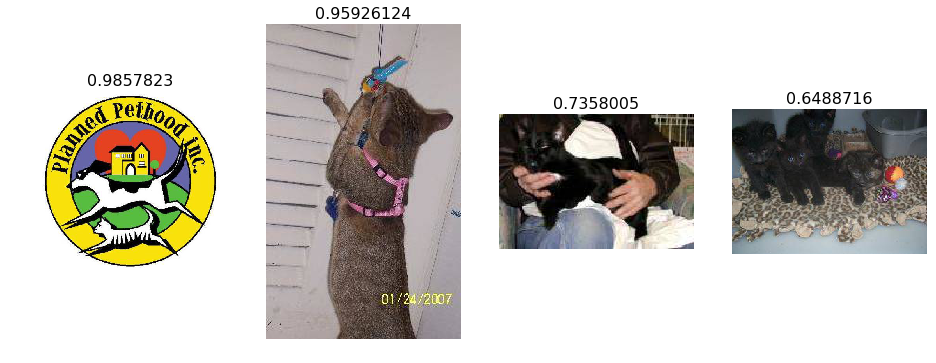

In [61]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


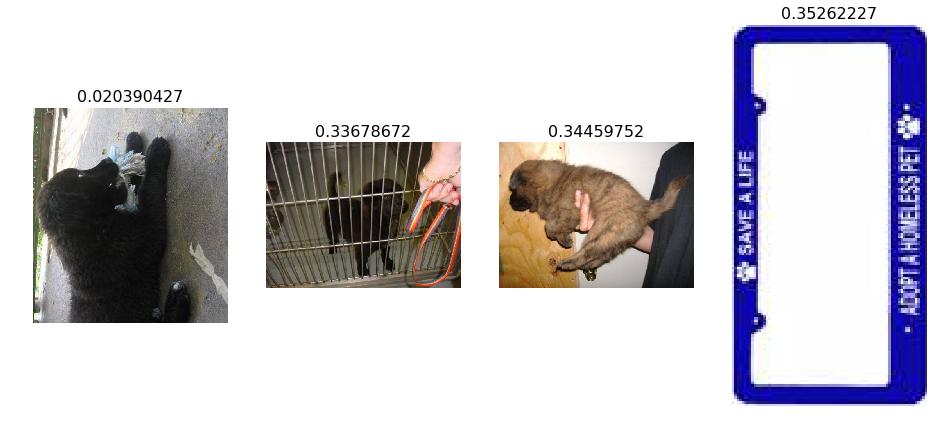

In [62]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")